In [1]:
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import pymc as pm

from pymc_marketing.bass.model import create_bass_model
from pymc_marketing.plot import plot_curve
from pymc_marketing.prior import Prior, Scaled

In [2]:
def setup_simulation_parameters(
    n_weeks: int = 52,
    n_products: int = 15,
    start_date: str = "2023-01-01",
    cutoff_start_date: str = "2023-12-01",
) -> tuple[
    npt.NDArray[np.int_],
    pd.DatetimeIndex,
    pd.DatetimeIndex,
    list[str],
    pd.Series,
    dict[str, Any],
]:
    """Set up initial parameters for the Bass diffusion model simulation."""
    seed = sum(map(ord, "Bass Model"))
    rng = np.random.default_rng(seed)

    # Create time array and date range
    T = np.arange(n_weeks)
    possible_dates = pd.date_range(start_date, freq="W-MON", periods=n_weeks)
    cutoff_start_date = pd.to_datetime(cutoff_start_date)
    cutoff_start_date = cutoff_start_date + pd.DateOffset(weeks=1)
    possible_start_dates = possible_dates[possible_dates < cutoff_start_date]

    # Generate product names and random start dates
    products = [f"P{i}" for i in range(n_products)]
    product_start = pd.Series(
        rng.choice(possible_start_dates, size=len(products)),
        index=pd.Index(products, name="product"),
    )

    coords = {"T": T, "product": products}
    return T, possible_dates, possible_start_dates, products, product_start, coords

In [4]:
def create_bass_priors():
    """Define prior distributions for the Bass model parameters."""
    return {
        "m": Scaled(Prior("Gamma", mu=1, sigma=0.001, dims="product"), factor=50_000),
        "p": Prior("Beta", mu=0.38, sigma=0.05, dims="product"),
        "q": Prior("Beta", mu=0.35, sigma=0.3, dims="product"),
        "likelihood": Prior("NegativeBinomial", n=1.5, dims="product"),
    }


def sample_and_plot_prior_predictive(model):
    """Sample from the prior predictive distribution and create initial plot."""
    with model:
        idata = pm.sample_prior_predictive()
    return idata.prior.y.sel(chain=0, draw=0)


def transform_to_actual_dates(bass_data, product_start, possible_dates):
    """Transform simulation data to actual calendar dates."""
    bass_data = bass_data.to_dataset()
    bass_data["product_start"] = product_start.to_xarray()

    df_bass_data = (
        bass_data.to_dataframe().drop(columns=["chain", "draw"]).reset_index()
    )
    df_bass_data["actual_date"] = df_bass_data["product_start"] + pd.to_timedelta(
        7 * df_bass_data["T"], unit="days"
    )

    return (
        df_bass_data.set_index(["actual_date", "product"])
        .y.unstack(fill_value=0)
        .reindex(possible_dates, fill_value=0)
    )

In [5]:
def main():
    """Run the Bass diffusion model simulation."""
    # Setup simulation parameters
    T, possible_dates, _, products, product_start, coords = (
        setup_simulation_parameters()
    )

    # Create and configure the Bass model
    priors = create_bass_priors()
    model = create_bass_model(t=T, coords=coords, observed=None, priors=priors)

    # Sample and visualize results
    bass_data = sample_and_plot_prior_predictive(model)
    actual_data = transform_to_actual_dates(bass_data, product_start, possible_dates)

    return bass_data, actual_data, model

Sampling: [m_unscaled, p, q, y]


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,2,0.24,127
,2000,1,0.24,31
,2000,4,0.22,31
,2000,1,0.23,95


Sampling: [y]


Output()

<xarray.DataArray 'diverging' ()> Size: 8B
array(8)


<Axes: >

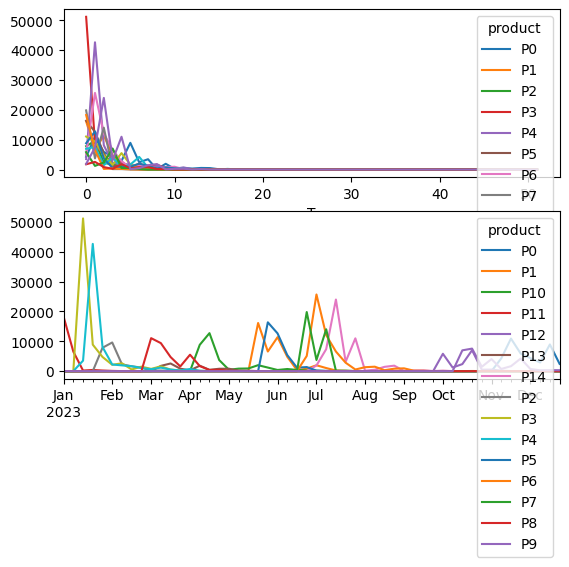

In [6]:
bass_data, actual_data, generative_model = main()

with pm.observe(generative_model, {"y": bass_data.values}) as model:
    idata = pm.sample(nuts_sampler="nutpie", compile_kwargs={"mode": "NUMBA"})

print(idata.sample_stats.diverging.sum())

pm.sample_posterior_predictive(idata, model=model, extend_inferencedata=True)


fig, axes = plt.subplots(2, 1)
bass_data.to_series().unstack().plot(ax=axes[0])

actual_data.plot(ax=axes[1])

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'product=P0'}, xlabel='T'>,
        <Axes: title={'center': 'product=P1'}, xlabel='T'>], dtype=object))

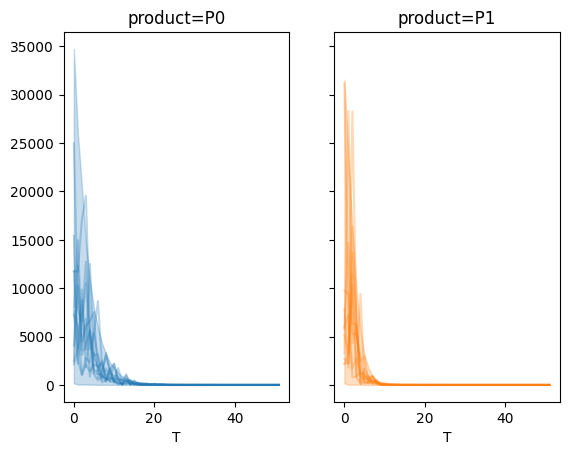

In [7]:
idata.posterior_predictive.y.sel(product=["P0", "P1"]).pipe(plot_curve, {"T"})